In [131]:
#import the working library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
%matplotlib inline

In [2]:
#read tickers as specified in excel in addition to market 
all_tickers = pd.read_excel('mapping.xlsx')[['Ticker', 'Market']]

In [3]:
#list all tickers
all_tickers

,Ticker,Market
0,ARGT,Emerging
1,EWA,Developed
2,EWO,Developed
3,EWK,Developed
4,EWZ,Emerging
5,EWC,Developed
6,ECH,Emerging
7,MCHI,Emerging
8,ICOL,Emerging
9,EDEN,Developed


In [202]:
#specified factor and date
factor_to_analyze = 'mr_63'
start_date_train = '2015-01-01'
end_date_train = '2018-12-31'
start_date_test = '2019-01-01'
end_date_test = '2019-12-31'

In [203]:
#list all etf in datafrome
all_etf_combined_df = pd.DataFrame()

#going throw each etf forward return 
for file in os.listdir('forward return'):
    fr_df = pd.read_csv('forward return/'+file, index_col='Date')
    fr_df['Ticker'] = file[:-4]
    try:
        factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
        combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'factor'}, axis=1)
        combined_df['factor'] = combined_df['factor'].fillna(method='ffill')
        all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
    except:
        continue
all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]

all_etf_combined_df['winsorized factor'] = np.nan
all_etf_combined_df['normalized winsorized factor'] = np.nan
all_etf_combined_df['normalized winsorized factor quartile'] = 0

#combine all factors
for date in all_etf_combined_df.index.get_level_values(0).unique():
    for market in ['Developed', 'Emerging']:
        n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
        all_etf_combined_df.loc[date].loc[market]['winsorized factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['factor'], limits=1/n_etf*2)
        all_etf_combined_df.loc[date].loc[market]['normalized winsorized factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['winsorized factor'])
        all_etf_combined_df.loc[date].loc[market]['normalized winsorized factor quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['normalized winsorized factor'], 5, labels=False)

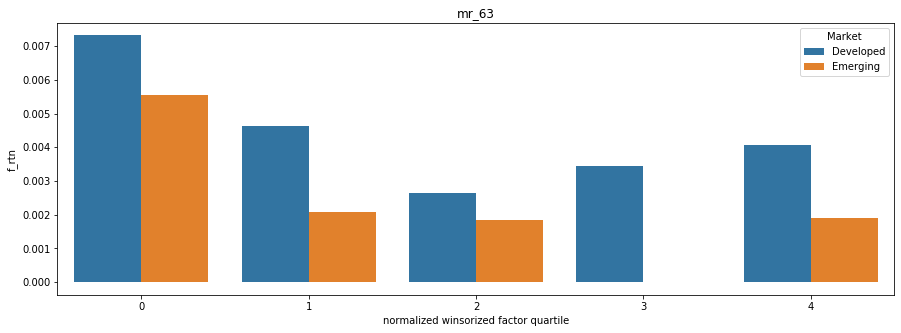

In [204]:
#factor quantile study by developed and emerging market
summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'normalized winsorized factor quartile']).mean()[['f_rtn']]
plt.figure(figsize=(15, 5))
sns.barplot(x='normalized winsorized factor quartile', y='f_rtn', hue='Market', data=summary_df.reset_index())
plt.title(factor_to_analyze)
plt.show()

In [205]:
#forward return in each market 
summary_df

f_rtn
Market    normalized winsorized factor quartile          
Developed 0                                      0.007317
          1                                      0.004625
          2                                      0.002653
          3                                      0.003445
          4                                      0.004064
Emerging  0                                      0.005561
          1                                      0.002073
          2                                      0.001834
          3                                     -0.000008
          4                                      0.001916

In [170]:
#save result into test csv
all_etf_combined_df.to_csv('test.csv')

In [77]:
#reorganize table by market
all_etf_combined_df.groupby(['Market'])

f_rtn    factor  winsorized factor  \
Date       Market    Ticker                                          
2015-01-02 Developed EDEN    0.015891  0.073955           0.073955   
                     EFNL    0.040772 -0.017174          -0.017174   
                     EIRL    0.029430  0.000940           0.000940   
                     EIS     0.007761 -0.010012          -0.010012   
                     ENOR    0.075848 -0.209467          -0.187163   
...                               ...       ...                ...   
2018-12-31 Emerging  PAK     0.120978 -0.300630          -0.300630   
                     QAT     0.052043  0.211525          -0.021842   
                     THD     0.097688 -0.075031          -0.075031   
                     TUR     0.176247 -0.413340          -0.309426   
                     UAE     0.038578 -0.143227          -0.143227   

                             normalized winsorized factor  \
Date       Market    Ticker                                 
2015-01-02 Developed EDEN                        1.420832   
                     EFNL                        0.243530   
                     EIRL                        0.477543   
                     EIS                         0.336056   
                     ENOR                       -1.952583   
...                                                   ...   
2018-12-31 Emerging  PAK                        -1.606755   
                     QAT                         1.376551   
                     THD                         0.807373   
                     TUR                        -1.700883   
                     UAE                         0.077608   

                             normalized winsorized factor quartile  
Date       Market    Ticker                                         
2015-01-02 Developed EDEN                                      NaN  
                     EFNL                                      NaN  
                     EIRL                                      NaN  
                     EIS                                       NaN  
                     ENOR                                      NaN  
...                                                            ...  
2018-12-31 Emerging  PAK                                       NaN  
                     QAT                                       NaN  
                     THD                                       NaN  
                     TUR                                       NaN  
                     UAE                                       NaN  

[46489 rows x 5 columns]

In [55]:
#specified start date in developed market
date = '2015-01-02'
market = 'Developed'

In [57]:
#combine all etf by market
n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]

In [61]:
#listed the specified date and market
all_etf_combined_df.loc[date].loc[market]['winsorized factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['factor'], limits=1/n_etf*2)
all_etf_combined_df.loc[date].loc[market]['normalized winsorized factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['winsorized factor'])

In [62]:
#show the result
all_etf_combined_df

f_rtn    factor  winsorized factor  \
Date       Market    Ticker                                          
2015-01-02 Developed EDEN    0.015891  0.073955           0.073955   
                     EFNL    0.040772 -0.017174          -0.017174   
                     EIRL    0.029430  0.000940           0.000940   
                     EIS     0.007761 -0.010012          -0.010012   
                     ENOR    0.075848 -0.209467          -0.187163   
...                               ...       ...                ...   
2018-12-31 Emerging  PAK     0.120978 -0.300630                NaN   
                     QAT     0.052043  0.211525                NaN   
                     THD     0.097688 -0.075031                NaN   
                     TUR     0.176247 -0.413340                NaN   
                     UAE     0.038578 -0.143227                NaN   

                             normalized winsorized factor  
Date       Market    Ticker                                
2015-01-02 Developed EDEN                        1.420832  
                     EFNL                        0.243530  
                     EIRL                        0.477543  
                     EIS                         0.336056  
                     ENOR                       -1.952583  
...                                                   ...  
2018-12-31 Emerging  PAK                              NaN  
                     QAT                              NaN  
                     THD                              NaN  
                     TUR                              NaN  
                     UAE                              NaN  

[46489 rows x 4 columns]

['ACWI.csv',
 'ARGT.csv',
 'ECH.csv',
 'EDEN.csv',
 'EFNL.csv',
 'EGPT.csv',
 'EIDO.csv',
 'EIRL.csv',
 'EIS.csv',
 'ENOR.csv',
 'ENZL.csv',
 'EPHE.csv',
 'EPOL.csv',
 'EPU.csv',
 'ERUS.csv',
 'EWA.csv',
 'EWC.csv',
 'EWD.csv',
 'EWG.csv',
 'EWH.csv',
 'EWI.csv',
 'EWJ.csv',
 'EWK.csv',
 'EWL.csv',
 'EWM.csv',
 'EWN.csv',
 'EWO.csv',
 'EWP.csv',
 'EWQ.csv',
 'EWS.csv',
 'EWT.csv',
 'EWU.csv',
 'EWW.csv',
 'EWY.csv',
 'EWZ.csv',
 'EZA.csv',
 'GREK.csv',
 'ICOL.csv',
 'INDA.csv',
 'KSA.csv',
 'MCHI.csv',
 'PAK.csv',
 'PGAL.csv',
 'QAT.csv',
 'THD.csv',
 'TUR.csv',
 'UAE.csv',
 'VOO.csv']